# Fairness-unaware binary classifiers

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, selection_rate, mean_prediction
from fairlearn.metrics import false_negative_rate, false_positive_rate
from fairlearn.metrics import true_negative_rate, true_positive_rate

In [2]:
DATA_PATH = "./data/"
PLOTS_PATH ="./plots/"

## Data processing and wrangling

In [3]:
def fetch_openml_dataset(choice):
    """Load dataset according to the choice from OpenML.

    Args:
        choice (str): dataset name

    Returns:
        X (pd.Dataframe): features
        y_true (pd.Series): true labels
    """
    if choice == "ACSincome":
        data = fetch_openml(data_id=43141, as_frame=True, parser='auto')
    elif choice == "IBADepression":
        data = fetch_openml(data_id=45040, as_frame=True, parser='auto')

    X = pd.get_dummies(data.data)
    y_true = data.target
    return {"features": X, "labels": y_true}

In [4]:
def num_to_percentile_category(target, num_classes=4):
    """Convert numerical target to categorical target based on quantile.

    Args:
        target (pd.Series): target series
        num_classes (int): number of classes

    Returns:
        target (pd.Series): categorical target series
    """
    y_true_categorical = pd.qcut(target, num_classes, labels=range(num_classes))
    return y_true_categorical

## Classifier and mitigators

In [5]:
class SklearnClfs:
    """Container for sklearn classifiers."""
    def __init__(self, clf_dict):
        """Initialize the container.

        Args:
            clf_dict (dict): Dictionary of classifiers.

        Example:
            from sklearn.tree import DecisionTreeClassifier
            clf_dict = {
                "Decision tree clf": DecisionTreeClassifier(max_depth=4),
            }
        """
        self._clf_dict = clf_dict

    def add_clf(self, clf_name, clf):
        """Add a new classifier.

        Args:
            clf_name (str): Name of the classifier.
            clf (sklearn classifier): The classifier.
        """
        self._clf_dict[clf_name] = clf

    def get_clf(self, clf_name):
        """Return the classifier by name.

        Args:
            clf_name (str): Name of the classifier.

        Returns:
            sklearn classifier: The classifier.
        """
        return self._clf_dict[clf_name]

    def get_clf_all(self):
        """Return all the classifiers.

        Returns:
            dict: The classifiers.
        """
        return self._clf_dict

    def fit_clf(self, clf_name, X, y):
        """Fit the classifier by name.

        Args:
            clf_name (str): Name of the classifier.
            X (np.array): Features.
            y (np.array): Labels.
        """
        self._clf_dict[clf_name].fit(X, y)

    def fit_clf_all(self, X, y):
        """Fit all the classifiers.

        Args:
            X (np.array): Features.
            y (np.array): Labels.
        """
        for clf_name in self._clf_dict:
            self.fit_clf(clf_name, X, y)

    def predict(self, clf_name, X):
        """Predict the labels using the classifier by name.

        Args:
            clf_name (str): Name of the classifier.
            X (np.array): Features.

        Returns:
            np.array: Predicted labels.
        """
        return self._clf_dict[clf_name].predict(X)

    def predict_all(self, X):
        """Predict the labels using all the classifiers.

        Args:
            X (np.array): Features.

        Returns:
            dict: Predicted labels.
        """
        return {clf_name: self.predict(clf_name, X) for clf_name in self._clf_dict}


In [6]:
class ExpGradMitigator:
    """Exponentiated gradient mitigation algorithm."""
    def __init__(self, estimator_dict, constraints, seed=2023):
        self._estimator_dict = estimator_dict
        self._mitigator_dict = None
        self._constraints = constraints
        self._seed = seed

    def get_mitigator(self, mitigator_name):
        """Return the mitigator by name.

        Args:
            mitigator_name (str): Name of the classifier.

        Returns:
            sklearn classifier: The classifier.
        """
        return self._mitigator_dict[mitigator_name]

    def get_mitigator_all(self):
        """Return all the mitigators.

        Returns:
            dict: The classifiers.
        """
        return self._mitigator_dict

    def fit_mitigator(self, mitigator_name, X, y_true, sensitive_features):
        """Fit the mitigator by name and update mitigator dictionary.

        Args:
            mitigator_name (str): Name of the classifier.
            X (np.array): Features.
            y_true (np.array): Labels.
            sensitive_features (np.array): Sensitive features.
        """
        if self._seed:
            np.random.seed(self._seed)
        estimator = self._estimator_dict[mitigator_name]
        mitigator = ExponentiatedGradient(
            estimator=estimator,
            constraints=self._constraints
        )
        mitigator.fit(X, y_true, sensitive_features=sensitive_features)
        self._mitigator_dict[mitigator_name] = mitigator

    def fit_mitigator_all(self, X, y_true, sensitive_features):
        """Fit all mitigators.

        Args:
            X (np.array): Features.
            y_true (np.array): Labels.
            sensitive_features (np.array): Sensitive features.
        """
        if self._seed:
            np.random.seed(self._seed)
        for mitigator_name in self._estimator_dict:
            self.fit_mitigator(mitigator_name, X, y_true, sensitive_features)

    def predict(self, mitigator_name, X):
        """Predict the labels using the mitigator by name.

        Args:
            mitigator_name (str): Name of the classifier.
            X (np.array): Features.

        Returns:
            np.array: Predicted labels.
        """
        return self._mitigator_dict[mitigator_name].predict(X)

    def predict_all(self, X):
        """Predict the labels using all the mitigators.

        Args:
            X (np.array): Features.

        Returns:
            np.array: Predicted labels.
        """
        y_pred_dict = {}
        for mitigator_name in self._mitigator_dict:
            y_pred_dict[mitigator_name] = self.predict(mitigator_name, X)
        return y_pred_dict

## Fairness evaluation

In [7]:
def customized_classification_report(y_true, y_pred, output_dict=True):
    """Customized classification report.

    Args:
        y_true (pd.Series): true labels
        y_pred (pd.Series): predicted labels
        output_dict (bool): whether to output dictionary
    
    Returns:
        classification_report (dict): classification report
    """
    return classification_report(y_true, y_pred, output_dict=output_dict)


def eval_binary_clf_fairness(y_true, y_pred, sensitive_features):
    """Evaluate fairness of the binary classifier.

    Args:
        y_true (pd.Series): true labels
        y_pred (pd.Series): predicted labels
        sensitive_features (pd.Series): sensitive features series

    Returns:
        metric_frame (fairlearn.metrics.MetricFrame): metric frame
    """
    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "confusion matrix": confusion_matrix,
        "classification report": customized_classification_report,
        "count": count,
        "mean prediction": mean_prediction,
        "selection rate": selection_rate,
        "false negative rate": false_negative_rate,
        "false positive rate": false_positive_rate,
        "true negative rate": true_negative_rate,
        "true positive rate": true_positive_rate
    }
    metric_frame = MetricFrame(metrics=metrics,
                               y_true=y_true,
                               y_pred=y_pred,
                               sensitive_features=sensitive_features)
    return metric_frame

In [8]:
def plot_binary_fairness_metrics_by_group(metric_frame, xticks, title, save_path=None):
    """Plot binary fairness metrics by group.

    Args:
        metric_frame (fairlearn.metrics.MetricFrame): metric frame
        xticks (list): x-axis ticks
        title (str): title of the plot
        save_path (str): path to save the plot
    """
    plt.figure(figsize=(18, 18))
    reindexed_metric_frame = metric_frame.by_group.copy()
    reindexed_metric_frame.index = xticks
    reindexed_metric_frame.index.name = metric_frame.by_group.index.name
    reindexed_metric_frame[["accuracy",
                            "precision",
                            "count",
                            "mean prediction",
                            "selection rate",
                            "false negative rate",
                            "false positive rate",
                            "true negative rate",
                            "true positive rate"]
                           ].plot(
                               kind="bar",
                               subplots=True,
                               layout=[3, 3],
                               legend=False,
                               figsize=[12, 8],
                               rot=45,
                               position=0,
                               title=title)
    if save_path:
        plt.savefig(save_path + title + ".png", bbox_inches='tight')

## Main

In [9]:
# Data

acs_income = fetch_openml_dataset("ACSincome")
X = acs_income["features"]
y_true = acs_income["labels"]
y_true_binary = num_to_percentile_category(y_true, 2)

In [10]:
# Define classifiers and mitigators

estimator_dict = {
    "Logistic regression": LogisticRegression(max_iter=1000),
    "Decistion tree classifier": DecisionTreeClassifier(max_depth=4),
    "Random forest classifier": RandomForestClassifier(max_depth=4),
    "AdaBoost classifier": AdaBoostClassifier(),
    "Multi-layer perceptron classifier": MLPClassifier(max_iter=1000)
}

In [11]:
# Train classifiers

clfs = SklearnClfs(estimator_dict)
clfs.fit_clf_all(X, y_true_binary)
y_pred_dict = clfs.predict_all(X)

In [12]:
# Evaluate fairness

sensitive_features = X["RAC1P"]
metrics = {}
for clf_type in clfs.get_clf_all():
    metric_frame = eval_binary_clf_fairness(y_true_binary,
                                            y_pred_dict[clf_type],
                                            sensitive_features)
    metrics[clf_type] = metric_frame

<Figure size 1800x1800 with 0 Axes>

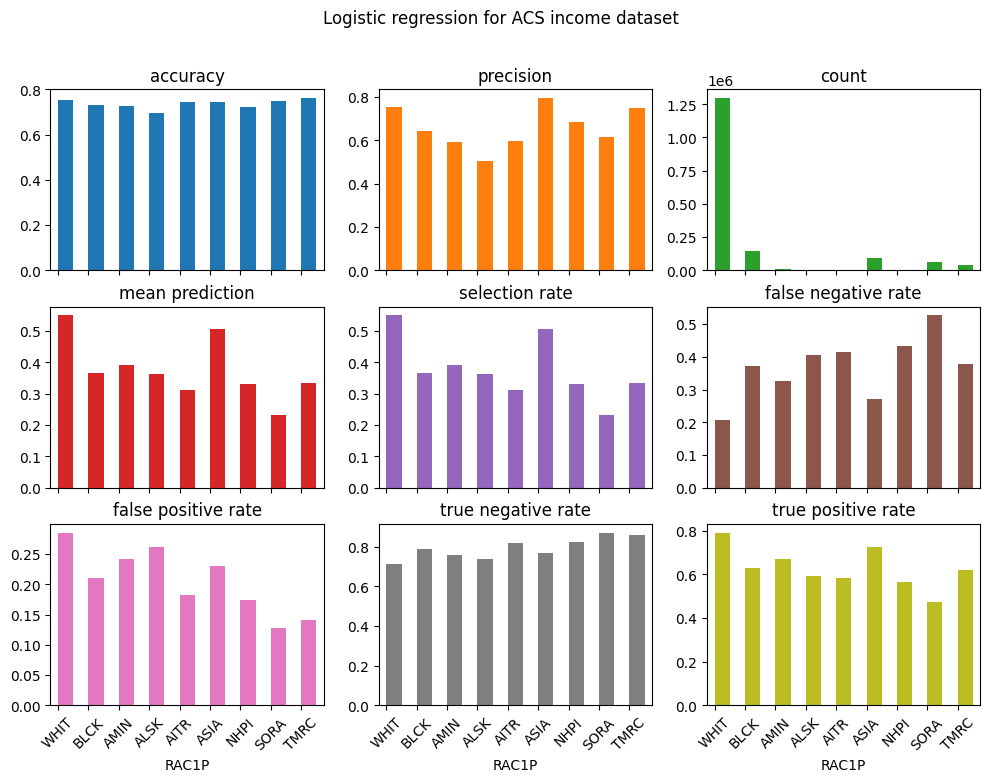

<Figure size 1800x1800 with 0 Axes>

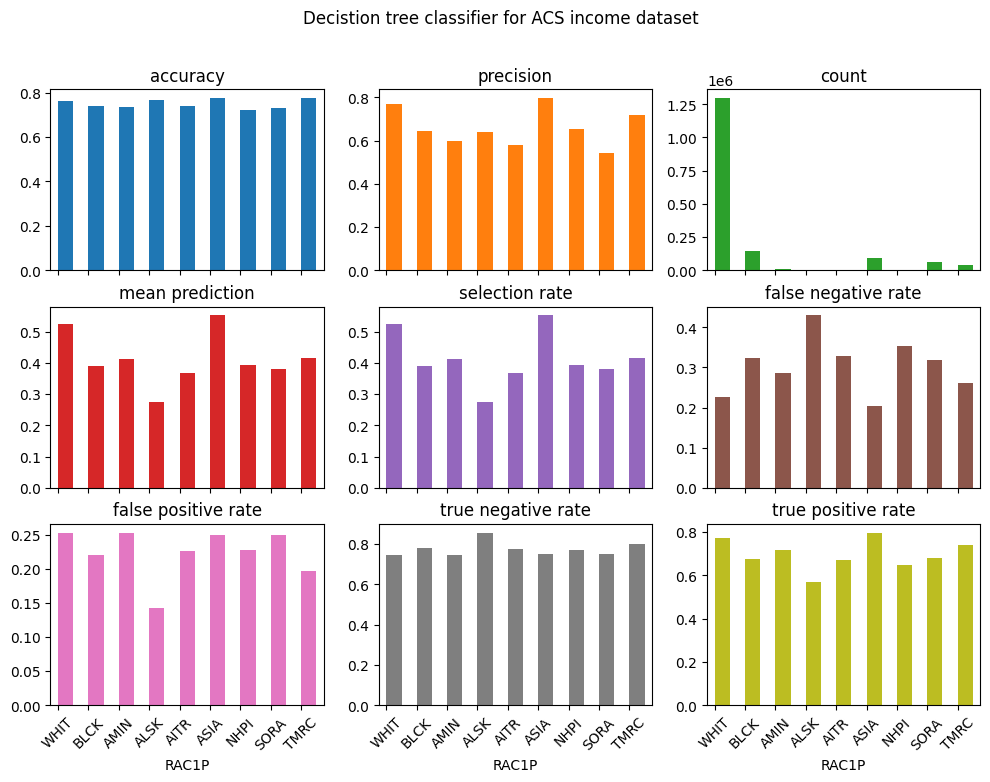

<Figure size 1800x1800 with 0 Axes>

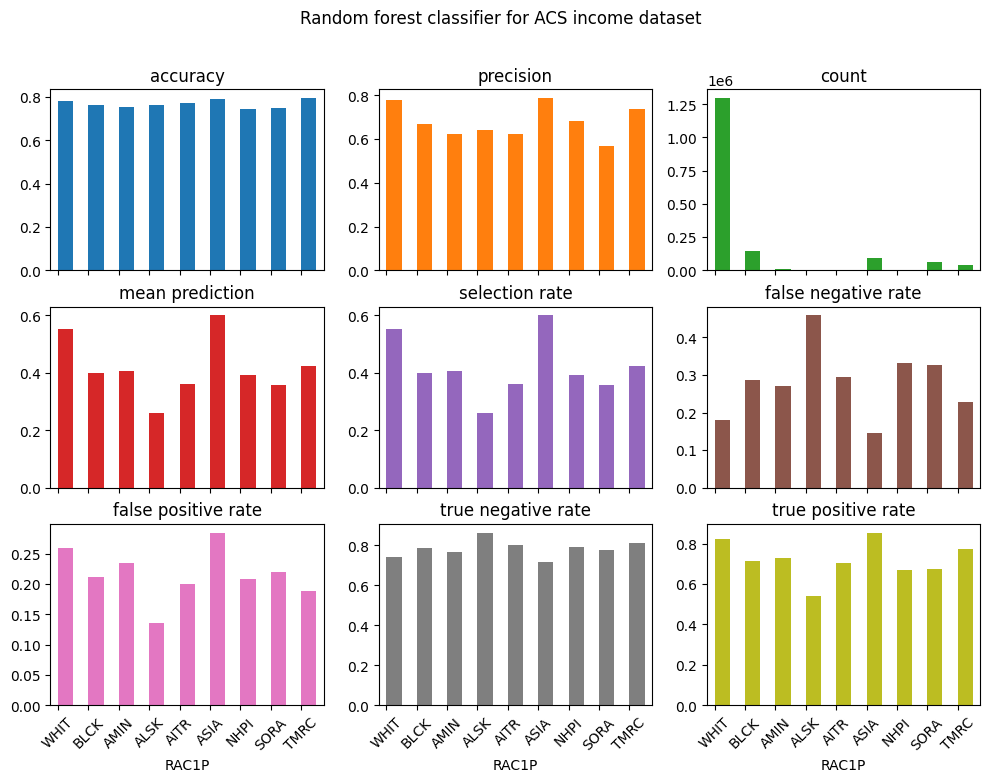

<Figure size 1800x1800 with 0 Axes>

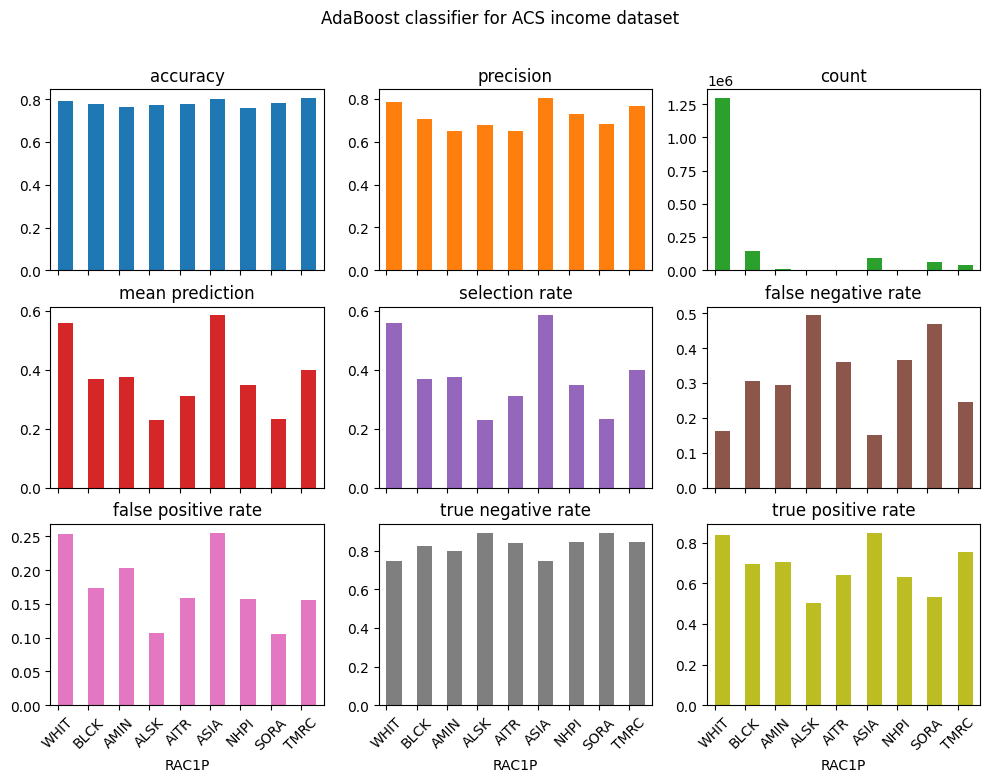

<Figure size 1800x1800 with 0 Axes>

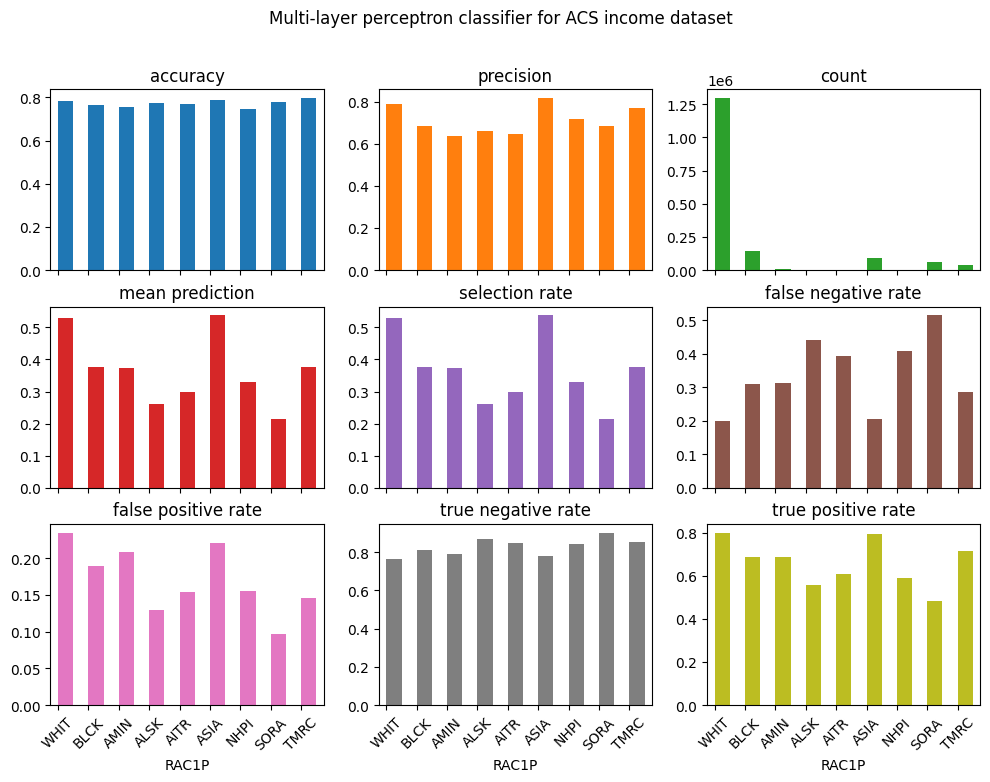

In [13]:
# Visualize fairness

xticks = ["WHIT", "BLCK", "AMIN", "ALSK", "AITR", "ASIA", "NHPI", "SORA", "TMRC"]
for clf_type in metrics:
    plot_binary_fairness_metrics_by_group(metrics[clf_type],
                                          xticks,
                                          clf_type + " for ACS income dataset")